In [0]:
# keep your existing vars
storage_account = "stnlpportfolioweu"
account_key = "paste_accountkey"

# 1) keep DFS config (ok to keep)
spark.conf.set(f"fs.azure.account.key.{storage_account}.dfs.core.windows.net", account_key)

# 2) ADD Blob endpoint config (this is the fix)
spark.conf.set(f"fs.azure.account.key.{storage_account}.blob.core.windows.net", account_key)

# Use BLOB endpoint paths (wasbs://)
raw_path_blob    = f"wasbs://nlp@{storage_account}.blob.core.windows.net/raw/aclImdb_v1.tar.gz"
curated_dir_blob = f"wasbs://nlp@{storage_account}.blob.core.windows.net/curated/"

print("Using BLOB endpoint paths:")
print("RAW :", raw_path_blob)
print("CURATED DIR:", curated_dir_blob)



Using BLOB endpoint paths:
RAW : wasbs://nlp@stnlpportfolioweu.blob.core.windows.net/raw/aclImdb_v1.tar.gz
CURATED DIR: wasbs://nlp@stnlpportfolioweu.blob.core.windows.net/curated/


In [0]:
import os, urllib.request

# local temp location
local_file = "/dbfs/tmp/aclImdb_v1.tar.gz"

# 1) download to Databricks local (about ~80 MB)
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
urllib.request.urlretrieve(url, local_file)

# 2) make sure the raw/ folder exists on your Blob container
dbutils.fs.mkdirs("wasbs://nlp@stnlpportfolioweu.blob.core.windows.net/raw")

# 3) upload to Blob raw/
dbutils.fs.cp(f"file:{local_file}",
              "wasbs://nlp@stnlpportfolioweu.blob.core.windows.net/raw/aclImdb_v1.tar.gz",
              recurse=False)

print("Uploaded to wasbs://nlp@stnlpportfolioweu.blob.core.windows.net/raw/aclImdb_v1.tar.gz")


Uploaded to wasbs://nlp@stnlpportfolioweu.blob.core.windows.net/raw/aclImdb_v1.tar.gz


In [0]:
import os, io, tarfile, urllib.request
from pyspark.sql import Row
from pyspark.sql import functions as F, types as T

# 1) Ensure local copy exists (download if missing)
local_tar = "/dbfs/tmp/aclImdb_v1.tar.gz"
if not os.path.exists(local_tar):
    url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    print("Downloading IMDB tar.gz (~80MB)...")
    urllib.request.urlretrieve(url, local_tar)
    print("Download complete.")

# 2) Stream-read the tar.gz WITHOUT extracting to disk
def iter_reviews(tar, split):
    """Yield (text, label:int, split:str) from a split (train/test), pos=1, neg=0."""
    prefix_pos = f"aclImdb/{split}/pos/"
    prefix_neg = f"aclImdb/{split}/neg/"
    for m in tar.getmembers():
        name = m.name
        if m.isfile():
            if name.startswith(prefix_pos):
                f = tar.extractfile(m)
                if f: 
                    yield f.read().decode("utf-8", errors="ignore"), 1, split
            elif name.startswith(prefix_neg):
                f = tar.extractfile(m)
                if f:
                    yield f.read().decode("utf-8", errors="ignore"), 0, split

rows = []
with tarfile.open(local_tar, "r:gz") as tar:
    rows.extend(iter_reviews(tar, "train"))
    rows.extend(iter_reviews(tar, "test"))

print(f"Loaded {len(rows):,} labeled reviews into memory")

# 3) Build Spark DataFrame
schema = T.StructType([
    T.StructField("text",  T.StringType(), False),
    T.StructField("label", T.IntegerType(), False),
    T.StructField("split", T.StringType(), False),
])
df = spark.createDataFrame(rows, schema=schema)

# Minimal clean (remove <br/> etc.)
import re
@F.udf("string")
def clean_text(s):
    s = re.sub(r"<br\s*/?>", " ", s)
    s = re.sub(r"[^A-Za-z0-9.,!?;:'\"()\- ]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_clean = (df
    .withColumn("text_clean", clean_text(F.col("text")))
    .withColumn("text_len", F.length("text"))
    .drop("text")
)

display(df_clean.groupBy("split","label").count().orderBy("split","label"))

# 4) Write curated parquet to your Blob endpoint (partitioned by split)
out_path = curated_dir_blob + "imdb_reviews_parquet"
(df_clean
 .repartition("split")          # small shuffle by split
 .write.mode("overwrite")
 .partitionBy("split")
 .parquet(out_path))

print("Wrote curated dataset to:", out_path)


Loaded 50,000 labeled reviews into memory


split,label,count
test,0,12500
test,1,12500
train,0,12500
train,1,12500


Wrote curated dataset to: wasbs://nlp@stnlpportfolioweu.blob.core.windows.net/curated/imdb_reviews_parquet


In [0]:
# ---- Cell A: load curated dataset into pandas train/test ----

# If you restarted the notebook, make sure these exist.
# storage_account, account_key, and curated_dir_blob should already be set from earlier.
curated_parquet_path = curated_dir_blob + "imdb_reviews_parquet"

# Read from Parquet with Spark (fast + lazy), then convert each split to pandas
df_spark = (spark.read
                 .parquet(curated_parquet_path)
                 .select("text_clean", "label", "split"))

# Train split -> pandas
train_spark = df_spark.where("split = 'train'").select("text_clean", "label")
train_df = train_spark.toPandas()

# Test split -> pandas
test_spark = df_spark.where("split = 'test'").select("text_clean", "label")
test_df = test_spark.toPandas()

# Features/labels for scikit-learn
X_train, y_train = train_df["text_clean"].values, train_df["label"].values
X_test,  y_test  = test_df["text_clean"].values,  test_df["label"].values

# Quick sanity checks
print("Train size:", len(X_train), "| Positives:", (y_train==1).sum(), "| Negatives:", (y_train==0).sum())
print("Test  size:", len(X_test),  "| Positives:", (y_test==1).sum(),  "| Negatives:", (y_test==0).sum())

# Peek at a couple reviews
for i in range(2):
    print(f"\nSample train[{i}] label={y_train[i]}:\n", X_train[i][:300], "...")


Train size: 25000 | Positives: 12500 | Negatives: 12500
Test  size: 25000 | Positives: 12500 | Negatives: 12500

Sample train[0] label=0:
 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h ...

Sample train[1] label=0:
 "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity ...


In [0]:
# ---- Cell B: TF-IDF + Logistic Regression (fit) ----
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import time

# Build a strong baseline pipeline
clf = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        ngram_range=(1, 2),    # unigrams + bigrams
        min_df=5,              # drop ultra-rare terms
        max_df=0.9,            # drop overly common terms
        max_features=200_000,  # cap vocab size (keeps memory in check)
    )),
    ("logreg", LogisticRegression(
        solver="liblinear",    # robust for sparse data
        penalty="l2",
        C=1.0,
        max_iter=1000,
        random_state=42
    ))
])

t0 = time.time()
clf.fit(X_train, y_train)
print(f"Model fitted in {time.time() - t0:.2f} s")

# Keep the trained pipeline in memory as `clf` for the next cell


Model fitted in 117.33 s


Accuracy : 0.8938
F1-score : 0.8943
ROC-AUC  : 0.9596

Classification report:
               precision    recall  f1-score   support

     neg (0)       0.90      0.89      0.89     12500
     pos (1)       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



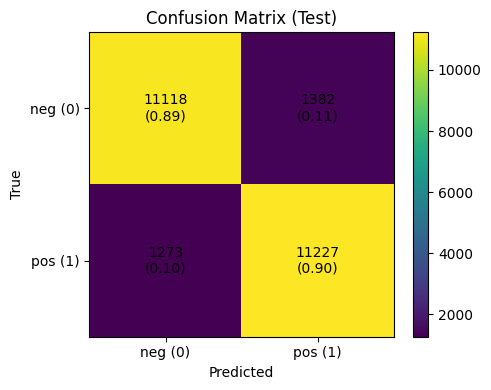

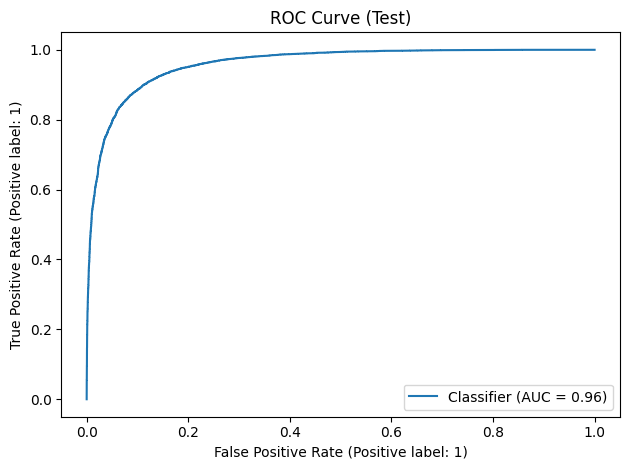

In [0]:
# ---- Cell C: evaluate the baseline model ----
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1) Predict
y_pred = clf.predict(X_test)
# some scikit-learn versions expose predict_proba; use decision_function fallback if not
if hasattr(clf[-1], "predict_proba"):
    y_prob = clf.predict_proba(X_test)[:, 1]
else:
    # scale decision_function to 0..1 (rough fallback)
    scores = clf.decision_function(X_test)
    y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

# 2) Metrics
acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {acc:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=["neg (0)", "pos (1)"]))

# 3) Confusion matrix (counts)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Plot confusion matrix (counts + normalized as text)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["neg (0)", "pos (1)"])
plt.yticks([0,1], ["neg (0)", "pos (1)"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, f"{v}\n({cm_norm[i,j]:.2f})", ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

# 4) ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve (Test)")
plt.tight_layout()
plt.show()


In [0]:
# === Export predictions & metrics to FileStore and print download URLs ===
import os, math
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# --- 1) sanity checks
vars_needed = ["X_test", "y_test", "y_pred"]
missing = [v for v in vars_needed if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables from evaluation step: {missing}. Run the evaluation cell first.")

# y_prob is optional for AUC
has_prob = "y_prob" in globals()

# --- 2) build DataFrames
predictions_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": y_pred,
    **({"pred_prob": y_prob} if has_prob else {})
})

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
auc = float("nan")
if has_prob:
    try:
        auc = roc_auc_score(y_test, y_prob)
    except Exception:
        pass

metrics_df = pd.DataFrame([{
    "accuracy": float(acc),
    "f1_score": float(f1),
    "roc_auc": auc
}])

# --- 3) save to /dbfs/tmp (always exists)
tmp_pred = "/dbfs/tmp/predictions.csv"
tmp_mets = "/dbfs/tmp/metrics.csv"
predictions_df.to_csv(tmp_pred, index=False)
metrics_df.to_csv(tmp_mets, index=False)

# --- 4) copy into /FileStore so they’re downloadable via /files/ URLs
dbutils.fs.mkdirs("dbfs:/FileStore")
dbutils.fs.cp("dbfs:/tmp/predictions.csv", "dbfs:/FileStore/predictions.csv", True)
dbutils.fs.cp("dbfs:/tmp/metrics.csv",      "dbfs:/FileStore/metrics.csv", True)

# --- 5) figure out your workspace URL for clickable links
try:
    host = dbutils.notebook.entry_point.getDbutils().notebook().getContext().browserHostName().get()
    base = f"https://{host}"
except Exception:
    base = "https://<your-workspace-url>"  # fallback: replace with your actual workspace URL

pred_url = f"{base}/files/predictions.csv"
mets_url = f"{base}/files/metrics.csv"

print("✅ Export complete.")
print("Download predictions:", pred_url)
print("Download metrics    :", mets_url)


✅ Export complete.
Download predictions: https://adb-1628863439761313.13.azuredatabricks.net/files/predictions.csv
Download metrics    : https://adb-1628863439761313.13.azuredatabricks.net/files/metrics.csv


In [0]:
import pandas as pd

metrics = pd.DataFrame([{
    "accuracy": float(acc),
    "f1_score": float(f1),
    "roc_auc": float(auc),
}])

metrics_out = curated_dir_blob.replace("curated", "scored") + "imdb_logreg_predictions/metrics_csv"
(
    spark.createDataFrame(metrics)
         .coalesce(1)
         .write.mode("overwrite")
         .option("header", "true")
         .csv(metrics_out)
)
print("Wrote metrics CSV to:", metrics_out)


Wrote metrics CSV to: wasbs://nlp@stnlpportfolioweu.blob.core.windows.net/scored/imdb_logreg_predictions/metrics_csv


In [0]:
# --- Cell M: robust metrics writer (CSV + JSON) to Blob endpoint ---

# 0) Imports
import json, math
import pandas as pd

from pyspark.sql import Row
from pyspark.sql import functions as F, types as T

# 1) Ensure these exist (edit storage_account / account_key if needed)
storage_account = globals().get("storage_account", "stnlpportfolioweu")  # <-- change if different
account_key     = globals().get("account_key", None)  # must be set earlier

if account_key is None:
    raise ValueError("account_key is not set. Set it like: account_key = '<your storage key>' and rerun Cell M.")

# Configure Blob endpoint (wasbs) – safe even if already set
spark.conf.set(f"fs.azure.account.key.{storage_account}.blob.core.windows.net", account_key)

# 2) Figure out metrics (use existing acc/f1/auc if present; else recompute quickly from y_test/y_pred/y_prob)
def _safe(name):
    return float(globals()[name]) if name in globals() and globals()[name] is not None and not (isinstance(globals()[name], float) and math.isnan(globals()[name])) else None

acc = _safe("acc")
f1  = _safe("f1")
auc = _safe("auc")

# If any are missing, recompute from predictions (requires y_test/y_pred/y_prob from earlier cell C)
if acc is None or f1 is None or auc is None:
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
    if "y_test" in globals() and "y_pred" in globals():
        acc = accuracy_score(y_test, y_pred)
        f1  = f1_score(y_test, y_pred)
        # y_prob may not exist for some solvers; guard it
        if "y_prob" in globals():
            try:
                auc = roc_auc_score(y_test, y_prob)
            except Exception:
                auc = None
    else:
        raise RuntimeError("Couldn't find metrics nor y_test/y_pred in memory. Please run Cell C first.")

metrics_dict = {"accuracy": float(acc), "f1_score": float(f1), "roc_auc": float(auc) if auc is not None else None}
print("Metrics:", metrics_dict)

# 3) Output paths (Blob endpoint)
scored_base = f"wasbs://nlp@{storage_account}.blob.core.windows.net/scored/imdb_logreg_predictions"
csv_dir     = scored_base + "/metrics_csv"
json_dir    = scored_base + "/metrics_json"

# 4) Write CSV (single file) using Spark
metrics_pdf = pd.DataFrame([metrics_dict])
spark.createDataFrame(metrics_pdf).coalesce(1).write.mode("overwrite").option("header", "true").csv(csv_dir)
print("Wrote CSV to:", csv_dir)

# 5) Write JSON (Spark JSON folder with one file)
spark.createDataFrame([Row(**metrics_dict)]).coalesce(1).write.mode("overwrite").json(json_dir)
print("Wrote JSON to:", json_dir)

# 6) List the folder to confirm
print("\nFolder listing (CSV):")
display(dbutils.fs.ls(csv_dir))
print("\nFolder listing (JSON):")
display(dbutils.fs.ls(json_dir))



In [0]:
import pandas as pd
import json

# 1) Build scored outputs DataFrame (pandas)
scored_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": y_pred,
    "pred_prob": y_prob
})

# Convert to Spark
scored_spark = spark.createDataFrame(scored_df)

# 2) Define scored output path
scored_out_path = curated_dir_blob.replace("curated", "scored") + "imdb_logreg_predictions"

# Write as Parquet (overwrite old runs)
scored_spark.write.mode("overwrite").parquet(scored_out_path)
print("Scored predictions written to:", scored_out_path)

# 3) Save metrics as JSON in scored/ folder
metrics = {
    "accuracy": float(acc),
    "f1_score": float(f1),
    "roc_auc": float(auc),
}
metrics_path = scored_out_path + "/metrics.json"
dbutils.fs.put(metrics_path.replace("wasbs://", "/dbfs/mnt/"), json.dumps(metrics), overwrite=True)

print("Metrics JSON written to:", metrics_path)


In [0]:
# ---- Cell E: verify scored outputs and metrics ----
scored_check_path = scored_out_path  # from Cell D

# List files written
print("Listing files in:", scored_check_path)
display(dbutils.fs.ls(scored_check_path))

# If you also want to peek at some scored rows:
scored_spark_read = spark.read.parquet(scored_check_path)
display(scored_spark_read.limit(5))


In [0]:
print("Predictions parquet:")
display(dbutils.fs.ls("wasbs://nlp@stnlpportfolioweu.blob.core.windows.net/scored/imdb_logreg_predictions"))

print("Metrics CSV folder:")
display(dbutils.fs.ls("wasbs://nlp@stnlpportfolioweu.blob.core.windows.net/scored/imdb_logreg_predictions/metrics_csv"))
